In [236]:
from datetime import datetime, timedelta
import bs4 as bs
import pickle
import requests
from tqdm import tqdm
from selenium import webdriver
import scraping_class
from bs4 import BeautifulSoup
import pandas as pd, pprint
import requests
import fuzzywuzzy
from fuzzywuzzy import fuzz
import time
logfile = 'my_log'## name your log file.
connector = scraping_class.Connector(logfile)

## API-function to request stock data. The call had to be made four times so in order to save you time, we have provided the final pickle files below so that there is no need to run the code below

In [ ]:
apikey = "JLTGEBBBDCQ9YHGT"

#create a function that stores the stock market data in a dictionary with the date as key
def process_range(id_range, store=None): 
    """process a number of ids, storing the results in a dict"""
    if store is None:
        store = {}
    for key, value in tqdm(id_range.items()):
        r, call_id = connector.get("https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol="+value+"&outputsize=full&interval=15min&apikey="+apikey, key)
        json_file = r.json()
        store[key] = json_file
        time.sleep(13)
    return store

# create a dictionary from the relevant tweets that consist of company tickers and date for tweet

relevant_df = pickle.load( open( "df_relevant.p", "rb" ) ) #load df consisting of tickers and tweet dates
tickers = relevant_df['Ticker']
relevant_dates = list(relevant_df['Timestamp'])
relevant_dates_f = [str(t) for t in relevant_dates]
company_dict = dict(zip(relevant_dates_f,tickers)) #create the tickers/date dictionary

# fetch the stock data for the companies and store them 
twitter_daily_data_1 = process_range(company_dict_1) #store the results of the call in a new variable

###
###
# to reduce time we split the numbers of calls that we had to make in 4. Therefore there is no need to run
# the code above and we advise that you instead use the pickle file added below containing the final results
###
###

## The code used to slice the dictionaries into four parts

In [237]:
relevant_df = pickle.load( open( "pickle_files/df_relevant.p", "rb" ) )
tickers = relevant_df['Ticker']

relevant_dates = list(relevant_df['Timestamp'])
relevant_dates_f = [str(t) for t in relevant_dates]


relevant_dates_0_200 = relevant_dates_f[0:200]
relevant_dates_200_400 = relevant_dates_f[200:400]
relevant_dates_400_600 = relevant_dates_f[400:600]
relevant_dates_600_ = relevant_dates_f[600:]

tickers_0_200 = tickers[0:200]
tickers_200_400 = tickers[200:400]
tickers_400_600 = tickers[400:600]
tickers_600_ = tickers[600:]

company_dict = dict(zip(relevant_dates_f,tickers))
company_dict_1 = dict(zip(relevant_dates_0_200,tickers_0_200))
company_dict_2 = dict(zip(relevant_dates_200_400,tickers_200_400))
company_dict_3 = dict(zip(relevant_dates_400_600,tickers_400_600))
company_dict_4 = dict(zip(relevant_dates_600_,tickers_600_))

### The final pickle files for company dictionaries above

In [238]:
company_dict_1 = pickle.load( open( "pickle_files/company_dict_1_f.p", "rb" ) )
company_dict_2 = pickle.load( open( "pickle_files/company_dict_2_f.p", "rb" ) )
company_dict_3 = pickle.load( open( "pickle_files/company_dict_3_f.p", "rb" ) )
company_dict_4 = pickle.load( open( "pickle_files/company_dict_4_f.p", "rb" ) )

company_dict_final = {}
for c in (company_dict_1,company_dict_2,company_dict_3,company_dict_4):
    company_dict_final.update(c)
    
# save final pickle
pickle.dump(company_dict_final, open( "company_dict_final.p", "wb" ) )

## The result of the API calls below in pickle files

In [249]:
# Combine the existing dictionaries to create one final dictionary consisting of 'date of tweet' as key and 
# stock values as value
t_dailyd_1 = pickle.load( open( "pickle_files/t_dailyd_1.p", "rb" ) )
t_dailyd_2 = pickle.load( open( "pickle_files/t_dailyd_2.p", "rb" ) )
t_dailyd_3 = pickle.load( open( "pickle_files/t_dailyd_3.p", "rb" ) )
t_dailyd_4 = pickle.load( open( "pickle_files/t_dailyd_4.p", "rb" ) )


t_daily_data = {}
for t in (t_dailyd_1,t_dailyd_2,t_dailyd_3,t_dailyd_4):
    t_daily_data.update(t)
    
# save final pickle
pickle.dump(t_daily_data, open( "t_daily_data.p", "wb" ) )

In [250]:
print (len(t_dailyd_1))
print (len(t_dailyd_2))
print (len(t_dailyd_3))
print (len(t_dailyd_4))

95
86
122
62


In [240]:
# pickle file to load data
t_daily_data = pickle.load( open( "t_daily_data.p", "rb" ) )

### The code below was used to sort the company dictionaries. 

In [214]:
error_keys = []
for key in company_dict_1.keys():
    if t_dailyd_1[key]=={'Note': 'Thank you for using Alpha Vantage! Our standard API call frequency is 5 calls per minute and 500 calls per day. Please visit https://www.alphavantage.co/premium/ if you would like to target a higher API call frequency.'}:
        error_keys.append(key)
    if t_dailyd_1[key]=={}:
        error_keys.append(key)
for key in error_keys:
    company_dict_1.pop(key)
for key in error_keys:
    t_dailyd_1.pop(key)

## Code to create singular data frames to later be concadenated

In [241]:
print (len(company_dict_1))
print (len(t_dailyd_1))

95
95


In [242]:
df_complete_1 = pd.DataFrame() #create empty dataframe to store final values
data = []
dict_complete_abs = {}

#define function to determine a bool that is either 1 or 0, depending on whether the pct. change is pos or neg

def pct_bool(df):
    pct_bool = []

    for x in df_date['pct_change']:
        if x > 0:
            pct_bool.append(1)
        else:
            pct_bool.append(0)

    df_date["pct_bool"] = pct_bool

# loop through the companies and their symbole
for key, value in company_dict_1.items():
    start_data = t_dailyd_1[key]['Time Series (Daily)']
    df = pd.DataFrame(start_data)
    df = df.T
    df['dates'] = key
    date = key[:10]
    df_date = df[date:date]
    df_date = df_date.iloc[:,[0,3,5,8]]
   
                         
    stock_open = df_date['1. open'].astype(float)
    stock_close = df_date['4. close'].astype(float)
    df_date['pct_change'] = ((stock_close-stock_open)/stock_open)*100
    pct_bool(df_date)
    df_date['ticker']=company_dict_1[key]
    df_date['1. open'] = df_date['1. open'].astype(float)
    df_date['4. close'] = df_date['4. close'].astype(float)
    df_date['6. volume'] = df_date['6. volume'].astype(float)
    
    frames = [df_complete_1,df_date]
    df_complete_1 = pd.concat(frames)

In [243]:
# The code above was used four times to create four dataframes. These dataframes are made avaiable underneath
df_complete_1 = pickle.load( open( "pickle_files/df_complete_1.p", "rb" ) )
df_complete_2 = pickle.load( open( "pickle_files/df_complete_2.p", "rb" ) )
df_complete_3 = pickle.load( open( "pickle_files/df_complete_3.p", "rb" ) )
df_complete_4 = pickle.load( open( "pickle_files/df_complete_4.p", "rb" ) )

# they were then used to create one final dataframe
frames = [df_complete_1,df_complete_2,df_complete_3,df_complete_4]
df_complete_final2 = pd.concat(frames)

## Create plot of percentage changes

In [244]:
# load dict that contains company tickers and date of tweet for specific company
company_dict_final = pickle.load( open( "company_dict_final.p", "rb") ) 

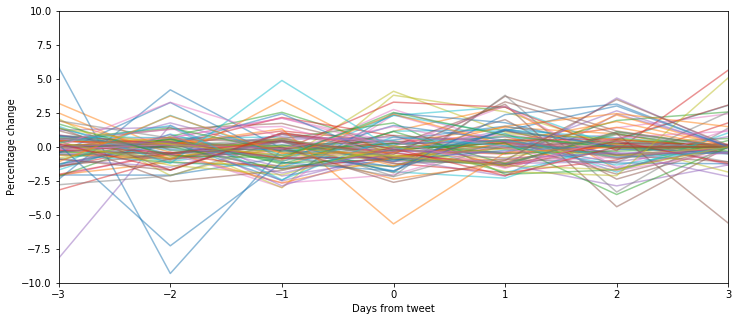

In [245]:
from datetime import datetime, timedelta
import bs4 as bs
import pickle
import requests
from selenium import webdriver
import scraping_class
from bs4 import BeautifulSoup
import pandas as pd, pprint
import time
import matplotlib.pyplot as plt
logfile = 'my_log'## name your log file.
connector = scraping_class.Connector(logfile)

dict_complete_abs = {}

for key, value in company_dict_final.items():
    start_data = t_daily_data[key]['Time Series (Daily)']
    df = pd.DataFrame(start_data)
    df = df.T
    df['dates'] = df.index

    date = key

    start_date1 = str(pd.date_range(date,periods=1)-pd.Timedelta(days=4)) #choose how many days we want in the df
    start_date = start_date1[16:26]

    end_date1 = str(pd.date_range(date,periods=1)+pd.Timedelta(days=6))
    end_date = end_date1[16:26]

    df_dates = df[end_date:start_date]
    liste = list(df_dates['5. adjusted close'])
    dict_complete_abs.update({value:liste})

df_g_complete = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in dict_complete_abs.items() ]))
df = df.fillna(0)
df_complete = df_g_complete.astype(float).pct_change(1)*100
df_complete = df_complete[1:-1]

# maybe delete outliers if possible, such as amazon

#add extra column to show days from tweet
days_from_tweet =[-3,-2,-1,0,1,2,3]
df_complete['days from tweet'] = days_from_tweet

#set index as new column
df_complete = df_complete.set_index('days from tweet')

# make a plot that displays the percentage changes in the closing values for the companies mentioned by Trump
df_complete.plot(figsize=(12,5),legend=False,alpha=0.5,ylim=[-10,10])
plt.xlabel('Days from tweet')
plt.ylabel('Percentage change')
plt.savefig('pct_change_stocks.png')
plt.show()

In [246]:
print (len(t_daily_data))

365


In [247]:
print (len(company_dict_final))

365
